# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download library

In [ ]:
"""
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip install tensorflow-addons
!pip install --upgrade --ignore-installed tensorflow
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
"""

'\n!/opt/conda/bin/python3.7 -m pip install --upgrade pip\n!pip install tensorflow-addons\n!pip install --upgrade --ignore-installed tensorflow\n!pip install -q imageio\n!pip install -q git+https://github.com/tensorflow/docs\n'

In [ ]:
!pip install tensorflow_addons

## Download data

In [ ]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
import os
import librosa
import numpy as np
def process_audio_segment(segment):
    # Your processing logic here
    # For example, you can extract features, apply filters, etc.
    segment = np.reshape(segment, (1, segment.shape[0]))
    return segment

def process_audio_files_in_directory(directory_path, segment_duration=5 , sampling_rate = 3000):
    processed_segments = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".wav"): # Process only .wav files
            # Load the audio file
            audio_path = os.path.join(directory_path, filename)
            audio, sr = librosa.load(audio_path, sr=sampling_rate, mono=True)

            # Calculate the total number of samples in the desired duration
            segment_samples = int(segment_duration * sr)

            # Calculate the number of segments
            num_segments = len(audio) // segment_samples

            # Process each segment
            for i in range(num_segments):
                # Extract a segment of the audio
                segment = audio[i * segment_samples : (i + 1) * segment_samples]

                # Process the segment
                processed_segment = process_audio_segment(segment)

                # Append the processed segment to the list
                #print(np.array(processed_segment).shape)
                processed_segments.append(processed_segment)

    return processed_segments

# Example usage:
# Directory containing your .wav files
########################################################
########################################################
########################################################
########################################################
genres = 'classical'
directory_path= '/content/drive/MyDrive/Data/genres_original/'+ genres
chunks_size = 30 # in seconds

batch_size = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 10
num_examples_to_generate = 10
sampling_rate =3000
beta = 100
input_size = chunks_size  * sampling_rate
########################################################
########################################################
########################################################
########################################################
processed_segments = process_audio_files_in_directory(directory_path, segment_duration=chunks_size ,sampling_rate = sampling_rate)

# Now you have a list of processed segments from all audio files in the directory
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Convert processed segments to numpy array
processed_segments_np = np.array(processed_segments)
valid_data = processed_segments_np[-10:]
processed_segments_np = processed_segments_np[:-10]
# Split the data into train and test sets
train_segments, test_segments = train_test_split(processed_segments_np, test_size=0.2, random_state=42)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_segments)
test_dataset = tf.data.Dataset.from_tensor_slices(test_segments)

# Shuffle and batch the datasets

train_dataset = train_dataset.shuffle(buffer_size=len(train_segments)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Optionally, you can prefetch the data to speed up training
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Now you can iterate over train_dataset and test_dataset using a TensorFlow model for training and testing.


In [ ]:
"""
!pip uninstall numpy -y
!pip install numpy
!pip install numba --upgrade

"""


'\n!pip uninstall numpy -y\n!pip install numpy\n!pip install numba --upgrade\n\n'

In [ ]:
"""
def plot_audio_waveform(dataset):
    # Convert dataset to numpy array
    audio_array = np.concatenate(list(dataset.as_numpy_iterator()))

    # Plot audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(audio_array[0][0])  # Plot the first audio chunk as an example
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.title('Audio Waveform')
    plt.show()
plot_audio_waveform(train_dataset)

"""

"\ndef plot_audio_waveform(dataset):\n    # Convert dataset to numpy array\n    audio_array = np.concatenate(list(dataset.as_numpy_iterator()))\n\n    # Plot audio waveform\n    plt.figure(figsize=(10, 4))\n    plt.plot(audio_array[0][0])  # Plot the first audio chunk as an example\n    plt.xlabel('Time (samples)')\n    plt.ylabel('Amplitude')\n    plt.title('Audio Waveform')\n    plt.show()\nplot_audio_waveform(train_dataset)\n\n"

In [ ]:
"""


assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch
"""

'\n\n\nassert BATCH_SIZE >= num_examples_to_generate\nfor test_batch in test_dataset.take(1):\n    test_sample = test_batch\n'

# Network Architecture

In [ ]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, type='encode'):
        super(Resnet1DBlock, self).__init__()

        if type == 'encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2, padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1, padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        elif type == 'decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1, padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1, padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)

        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(layers.Dropout(0.3)(x))
        #x = layers.LeakyReLU(0.4)(x)
        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(layers.Dropout(0.3)(x))
        #x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(layers.Dropout(0.3)(x))
        #return tf.nn.relu(x)



In [ ]:
from tensorflow.keras import layers, Model
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, input_size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_size = input_size
        self.encoder = self.build_encoder(self.latent_dim,self.input_size)
        self.decoder = self.build_decoder(self.latent_dim,self.input_size)

    def build_encoder(self,latent_dim, input_size):
        inputs = layers.Input(shape=(1, input_size))
        x = layers.Conv1D(64, 1, strides=2)(inputs)
        x = Resnet1DBlock(64, 1)(x)
        x = layers.Conv1D(128, 1, strides=2)(x)
        x = Resnet1DBlock(128, 1)(x)
        x = layers.Conv1D(128, 1, strides=2)(x)
        x = Resnet1DBlock(128, 1)(x)
        x = layers.Conv1D(256, 1, strides=2)(x)
        x = Resnet1DBlock(256, 1)(x)
        """
        #add more
        x = layers.Conv1D(256, 1, strides=2)(x)
        x = Resnet1DBlock(256, 1)(x)
        x = layers.Conv1D(512, 1, strides=2)(x)
        x = Resnet1DBlock(512, 1)(x)
        x = layers.Conv1D(512, 1, strides=2)(x)
        x = Resnet1DBlock(512, 1)(x)
        x = layers.Conv1D(1024, 1, strides=2)(x)
        x = Resnet1DBlock(1024, 1)(x)

        ##END
        """


        # No activation
        x = layers.Flatten()(x)
        outputs= layers.Dense(latent_dim+latent_dim)(x)
        """
        mean = layers.Dense(latent_dim)(x)
        log_var = layers.Dense(latent_dim)(x)

        """


        #return Model(inputs,[mean, log_var])
        return Model(inputs, outputs)

    def build_decoder(self,latent_dim, input_size):
        inputs = layers.Input(shape=(latent_dim,))
        x = layers.Reshape(target_shape=(1, latent_dim))(inputs)
        """
        #add more  1024
        x = Resnet1DBlock(2048, 1, 'decode')(x)
        x = layers.Conv1DTranspose(1024, 1, 1)(x)
        x = Resnet1DBlock(2048, 1, 'decode')(x)
        x = layers.Conv1DTranspose(1024, 1, 1)(x)

        ##END
        """
        x = Resnet1DBlock(512, 1, 'decode')(x)
        x = layers.Conv1DTranspose(512, 1, 1)(x)
        x = Resnet1DBlock(256, 1, 'decode')(x)
        x = layers.Conv1DTranspose(256, 1, 1)(x)
        x = Resnet1DBlock(128, 1, 'decode')(x)
        x = layers.Conv1DTranspose(128, 1, 1)(x)
        x = Resnet1DBlock(64, 1, 'decode')(x)
        x = layers.Conv1DTranspose(64, 1, 1)(x)
        outputs = layers.Conv1DTranspose(input_size, 1, 1)(x)
        return Model(inputs, outputs)
    def get_metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstruction= self.decode(z)
        return z_mean, z_log_var, z, reconstruction
    @tf.function
    def update(self,encoder,decoder):
        self.encoder = encoder
        self.decoder = decoder
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x,training= False ):
        #mean, logvar = self.encoder(x)
        #mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        mean, logvar = tf.split(self.encoder(x,training=training), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))#eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False ,training= False ):
        #logits = self.decoder(z)
        logits = self.decoder(z,  training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    """
    def train_step(self, data):

       #Step run during training
        x= data
        with tf.GradientTape() as tape:
            # FOWARD
            #mean, logvar, x_logit ,z = self(x, training=True)
            mean, logvar = self.encode(x)
            z = self.reparameterize(mean, logvar)
            x_logit = self.decode(z)

            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            #KL_loss COMPUTE
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            #reconstruction_loss COMPUTE
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL * beta

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #gradients = tape.gradient(total_loss, model.trainable_variables)
        #optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        #Step run during validation.
        if isinstance(data, tuple):
            data = data[0]

        x= data

        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)

       # mean, logvar, x_logit,z = self(x)

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        # KL
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        # Reconstruction
        reconstruction_loss = tf.reduce_mean(
                             tf.keras.losses.binary_crossentropy(x, x_logit)
                         )
        total_loss = reconstruction_loss+ loss_KL
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss":loss_KL,
        }

        """

In [ ]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [ ]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)

    z = model.reparameterize(mean, logvar)

    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Loss Optimization

In [ ]:
@tf.function
def train_step(model, x, optimizer):

    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:

            mean, logvar = model.encode(x,training = True )
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z,training = True )
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)

            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL*beta

    if tf.math.is_nan(total_loss) or loss_KL > 200000 or loss_KL < -200000 : # if total_loss is 'nan' or 'less than threshold '
        print("Invalid loss detected. Skipping update.")
    else:
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return reconstruction_loss, loss_KL


# Train Function

In [ ]:

import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    #print(mean.shape)
    #print(logvar.shape)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):

        plt.subplot(4, 4, i + 1)
        librosa.display.waveshow(np.array(predictions[i]), sr=sampling_rate)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [ ]:
import time
import numpy as np
from keras.models import load_model, save_model


import copy
tf.keras.utils.get_custom_objects()['Resnet1DBlock'] = Resnet1DBlock
# Function to train the model
def train(train_dataset, test_dataset, model, genres):
    model_path = '/content/drive/MyDrive/'
    max_elbo = float('-inf')
    temp_model = (model.encoder, model.decoder)  # Initialize temp_model
    best_model = temp_model  # Initialize best_model
    losses_KL = []  # List to store KL divergence losses for each epoch
    losses_reconstruction = []  # List to store reconstruction losses for each epoch
    elbo_list = []
    for epoch in range(1, epochs + 1):
        start_time = time.time()

        # Save the model at the beginning of each epoch
        save_model(model.encoder, model_path + '/temp_encoder.keras')
        save_model(model.decoder, model_path + '/temp_decoder.keras')

        for train_x in train_dataset:
            train_x = np.asarray(train_x)
            loss_reconstruction_epoch, loss_KL_epoch= train_step(model, train_x, optimizer) # train and update weight

        end_time = time.time()
        #reconstruction_loss, loss_KL
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)

            #test_x = np.reshape(test_x, (test_x.shape[0], 1,test_x.shape[1]))
            loss(compute_loss(model, test_x))


        elbo = -loss.result()
        losses_KL.append(loss_KL_epoch)
        losses_reconstruction.append(loss_reconstruction_epoch)
        elbo_list.append(elbo)
        """
        # Check if ELBO is NaN or above threshold
        threshold = -2000
        if np.isnan(elbo) or elbo > threshold:
            print("ELBO is NaN or above threshold. Reloading the previous model.")
            encoder =load_model(model_path + '/temp_encoder.keras')
            decoder = load_model(model_path + '/temp_decoder.keras')
            model.update(encoder, decoder)
        else:
            # Save model if ELBO improves
            if elbo > max_elbo:
                max_elbo = elbo
                print(f'new max elbo {max_elbo}')
                save_model(model.encoder, model_path + '/temp_best_encoder.keras')
                save_model(model.decoder, model_path + '/temp_best_decoder.keras')
                temp_model = (model.encoder, model.decoder)  # Update temp_model
            else :
                encoder =load_model(model_path + '/temp_best_encoder.keras')
                decoder = load_model( model_path + '/temp_best_decoder.keras')
                model.update(encoder, decoder)
              """
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapsed for current epoch: {}'.format(epoch, elbo, end_time - start_time))

    # Save the best model at the end of all epochs
    save_model(temp_model[0], model_path + '/best_encoder.keras')
    save_model(temp_model[1], model_path + '/best_decoder.keras')
    best_model = temp_model

    return best_model,losses_KL, losses_reconstruction,elbo_list


# Initialize model

In [ ]:
optimizer =  tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [ ]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim,input_size)


In [ ]:
"""


assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch
generate_and_save_images(model, 0, test_sample, 'blues')

"""

"\n\n\nassert batch_size >= num_examples_to_generate\nfor test_batch in test_dataset.take(1):\n    test_sample = test_batch\ngenerate_and_save_images(model, 0, test_sample, 'blues')\n\n"

In [ ]:
epochs = 20
best_model,losses_KL, losses_reconstruction,elbo_list= train(train_dataset, test_dataset, model, genres)

Epoch: 20, Test set ELBO: -2842.48974609375, time elapsed for current epoch: 1.6948833465576172


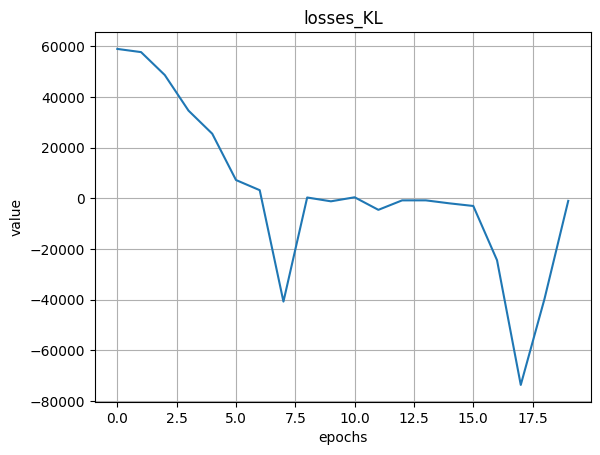

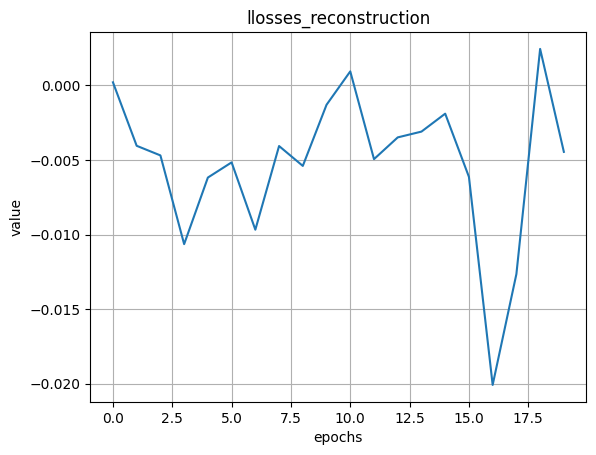

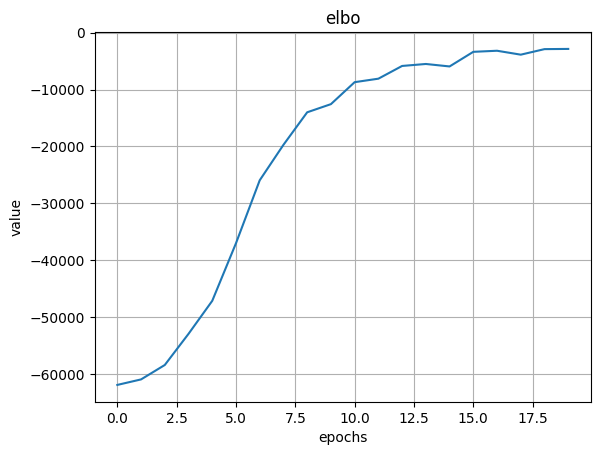

In [ ]:
import matplotlib.pyplot as plt

def plot_array(array, name):
    plt.plot(np.array(array))
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title(name)
    plt.grid(True)
    plt.show()

# Example usage:
name = 'losses_KL'
plot_array((losses_KL), name)
name = 'llosses_reconstruction'
plot_array((losses_reconstruction), name)
name = 'elbo'
plot_array((elbo_list), name)

In [ ]:
losses_KL

[<tf.Tensor: shape=(), dtype=float32, numpy=58965.71>,
 <tf.Tensor: shape=(), dtype=float32, numpy=57707.438>,
 <tf.Tensor: shape=(), dtype=float32, numpy=48659.695>,
 <tf.Tensor: shape=(), dtype=float32, numpy=34617.96>,
 <tf.Tensor: shape=(), dtype=float32, numpy=25505.564>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7241.3647>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3230.2642>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-40718.945>,
 <tf.Tensor: shape=(), dtype=float32, numpy=349.14825>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1161.5183>,
 <tf.Tensor: shape=(), dtype=float32, numpy=429.8912>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-4523.3096>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-786.42114>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-781.0124>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1965.8953>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-3000.165>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-24408.309>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-

In [ ]:
"""
save_model(model.encoder, model_path + '/encoder_10k_E10.keras')
save_model(model.decoder, model_path +  '/decoder_10k_E10.keras')

"""

"\nsave_model(model.encoder, model_path + '/encoder_10k_E10.keras')\nsave_model(model.decoder, model_path +  '/decoder_10k_E10.keras')\n\n"

# Generated music

In [ ]:
def inference(test_dataset, model):
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

# Check result from test sample for model performance .

In [ ]:
# WHOLE TEST SAMPLE
saved_musics = inference(test_dataset, model)


In [ ]:
np.array(saved_musics).shape

(18, 1, 90000)

In [ ]:
import numpy as np

all_data = []

# Iterate through test_dataset to append each data point
for data in test_dataset:
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)
all_data_test=np.array(all_data).reshape((np.array(saved_musics).shape[0],np.array(saved_musics).shape[1],np.array(saved_musics).shape[2]))
all_data_test.shape

(18, 1, 90000)

In [ ]:
music1=saved_musics[0][0]
ipd.Audio(all_data_test[0][0],rate=sampling_rate)

In [ ]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=sampling_rate)

In [ ]:
music1=saved_musics[8][0]
ipd.Audio(music1,rate=sampling_rate)

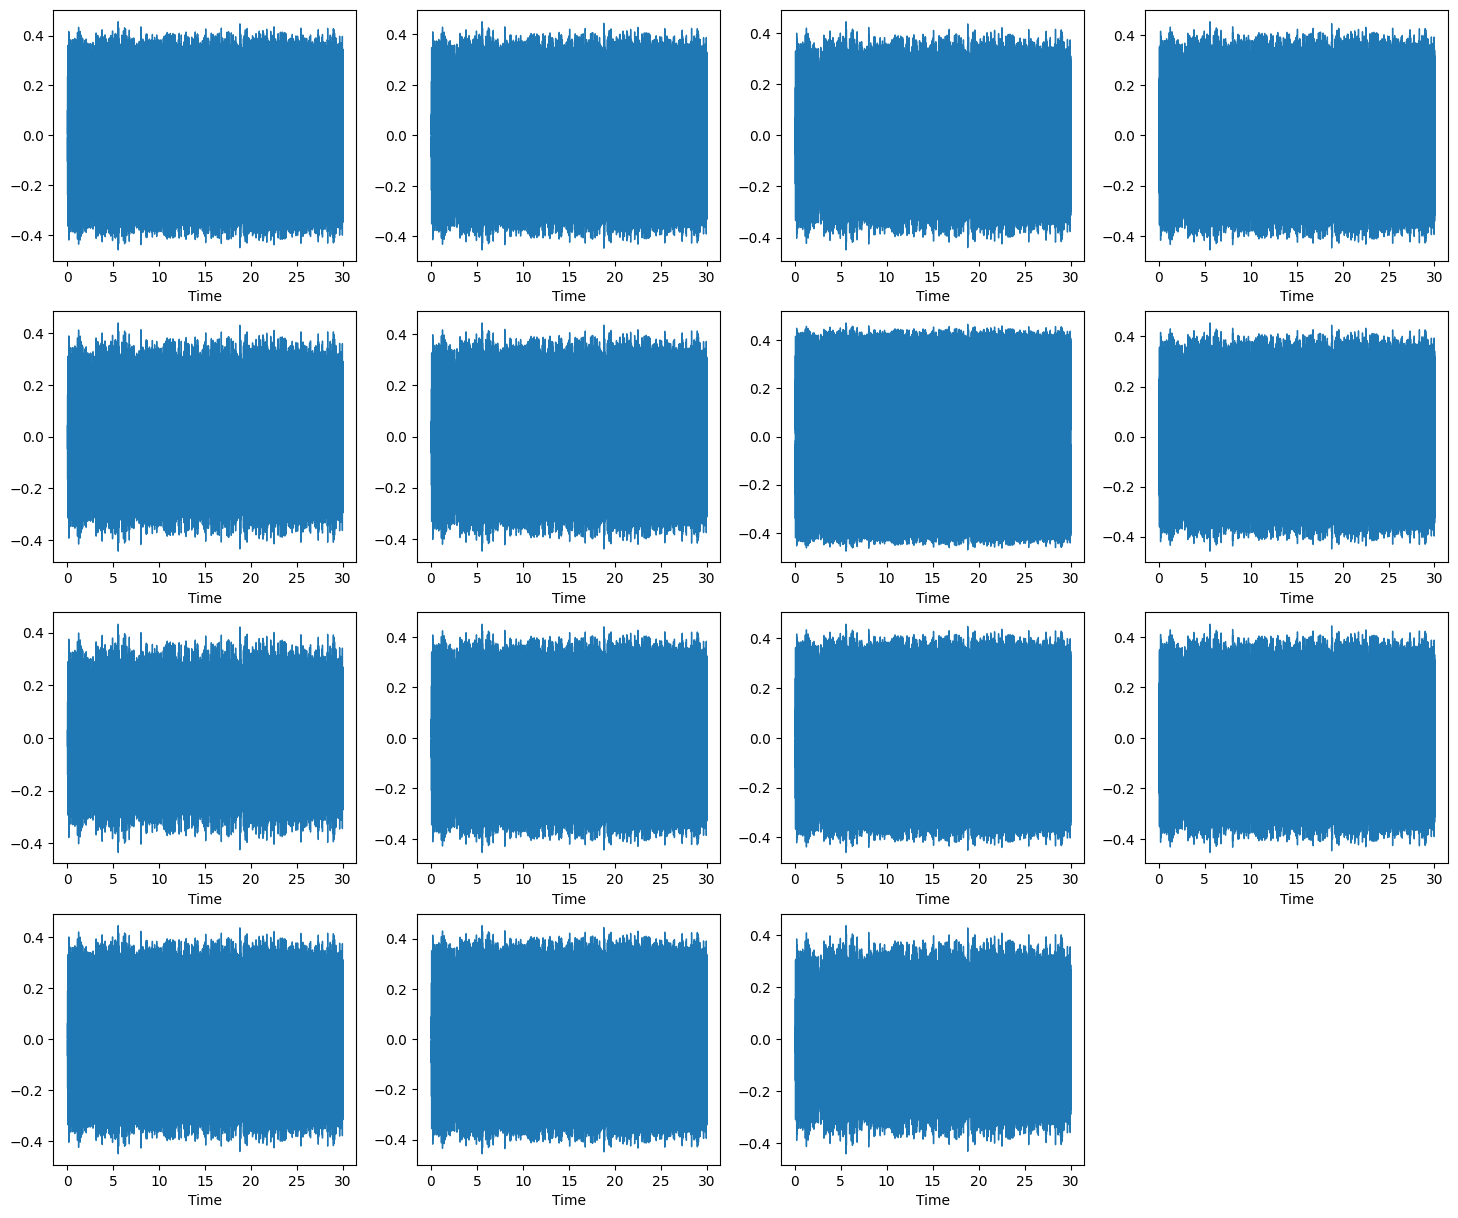

In [ ]:
import librosa
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 15))

for i in range(15):
    plt.subplot(4, 4, i + 1)
    librosa.display.waveshow(saved_musics[i][0], sr=sampling_rate)

plt.show()


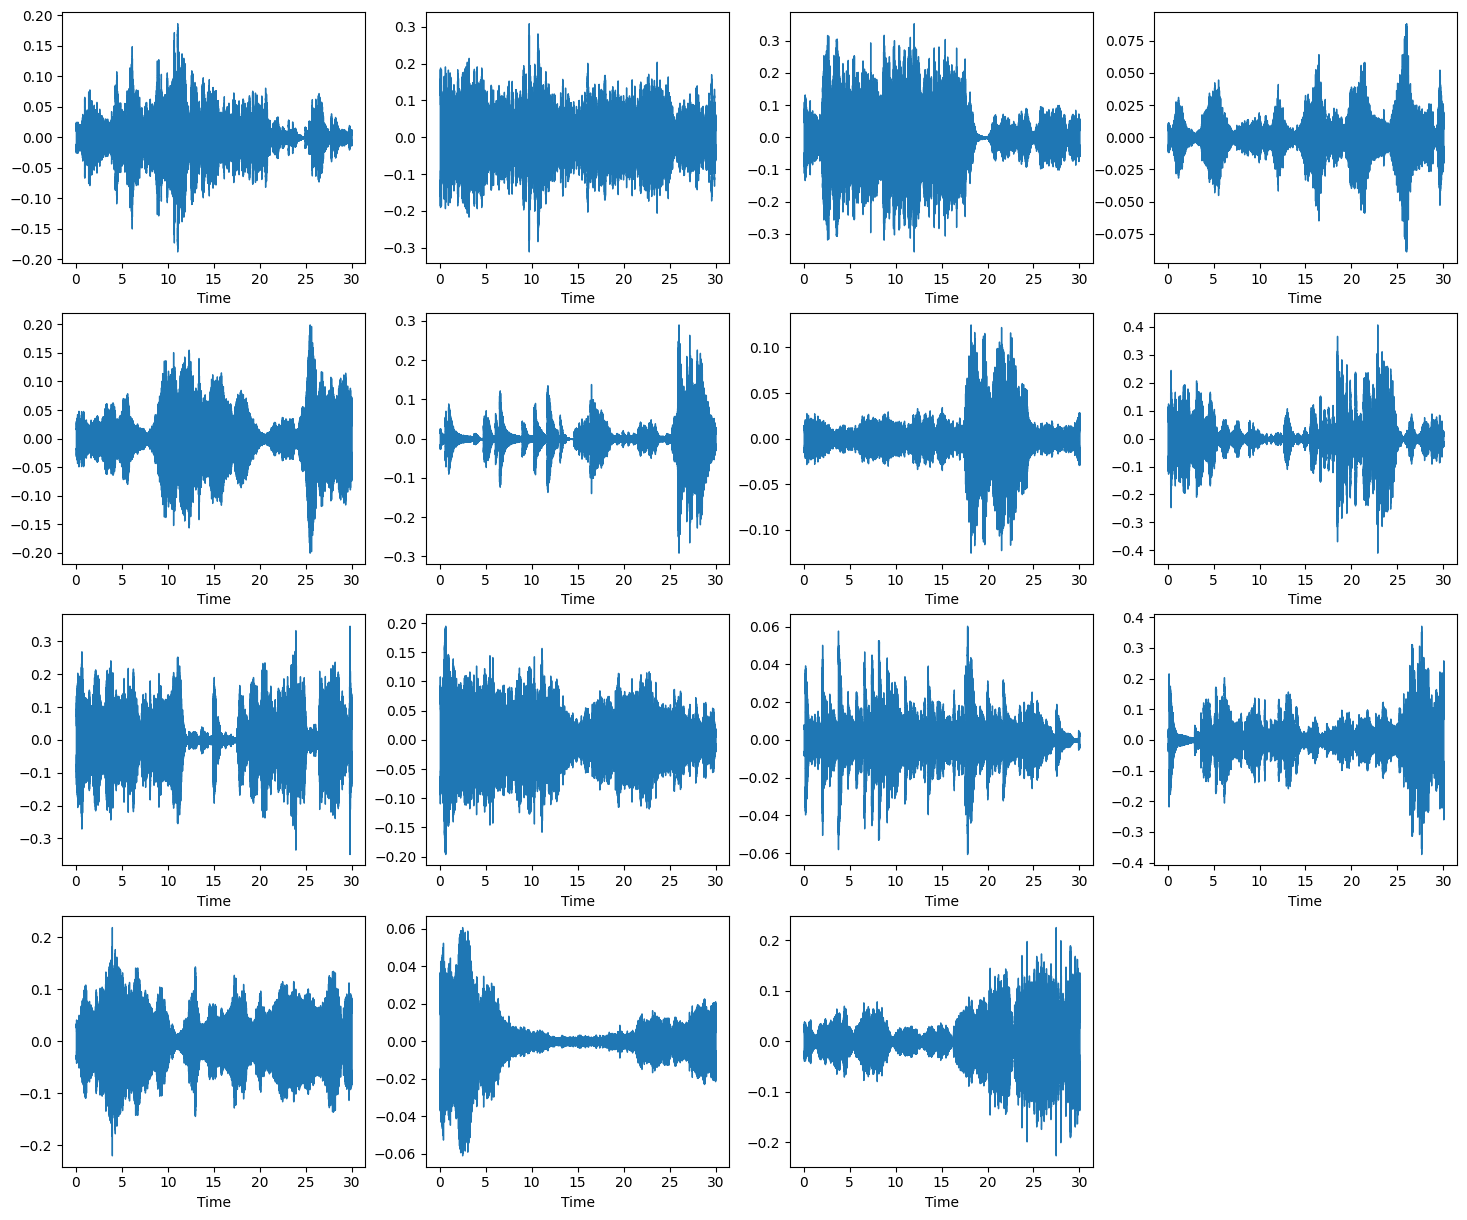

In [ ]:
import librosa
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 15))

for i in range(15):
    plt.subplot(4, 4, i + 1)
    librosa.display.waveshow(all_data_test[i][0], sr=sampling_rate)

plt.show()


In [ ]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm
from keras.models import Model

# calculate frechet inception distance using encoder of VAE model

def calculate_fid(encoder, audio1, audio2): #( inception model , audio1 , audio2 )
    # encode audio using the encoder
    enc1 = encoder.predict(audio1) # (batch , laten space of audio 1 )

    enc2 = encoder.predict(audio2) # (batch , laten space of audio 1 )

    # calculate mean and covariance statistics
    mu1, sigma1 = enc1.mean(axis=0), cov(enc1, rowvar=False)
    mu2, sigma2 = enc2.mean(axis=0), cov(enc2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid_diff = calculate_fid(model.encoder,all_data_test[:10],np.array(saved_musics)[:10])
fid_same = calculate_fid(model.encoder,np.array(saved_musics)[:10],np.array(saved_musics)[:10])
print(f'FID Difference(Should be High): {fid_diff}')
print(f'FID Same(Should close to 0): {fid_same}')


1/1 [==============================] - 0s 27ms/step
FID Difference(Should be High): 267.23567811531683
FID Same(Should close to 0): -8.967955605887739e-07


# Check result from train sample for model overfitting ??

In [ ]:

saved_music_train = inference(train_dataset, model)

In [ ]:

all_data = []

for data in train_dataset:
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)
all_data_train=np.array(all_data).reshape((np.array(saved_music_train).shape[0],np.array(saved_music_train).shape[1],np.array(saved_music_train).shape[2]))
all_data_train.shape

(70, 1, 90000)

In [ ]:

fid_diff = calculate_fid(model.encoder,all_data_train[:10],np.array(saved_music_train)[:10])
fid_same = calculate_fid(model.encoder,np.array(saved_music_train)[:10],np.array(saved_music_train)[:10])
print(f'FID Difference(Should be High): {fid_diff}')
print(f'FID Same(Should close to 0): {fid_same}')


1/1 [==============================] - 0s 27ms/step
FID Difference(Should be High): 181.60178975294923
FID Same(Should close to 0): -1.1602652653201762e-06


In [ ]:

valid_dataset = tf.data.Dataset.from_tensor_slices(valid_data).batch(batch_size)
valid_data.shape

(10, 1, 90000)

In [ ]:

saved_music_valid = inference(valid_dataset, model)

In [ ]:

all_data = []

for data in valid_dataset:
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)
all_data_valid=np.array(all_data).reshape((np.array(saved_music_valid).shape[0],np.array(saved_music_valid).shape[1],np.array(saved_music_valid).shape[2]))
all_data_valid.shape

(10, 1, 90000)

In [ ]:

fid_diff = calculate_fid(model.encoder,all_data_valid,np.array(saved_music_valid))
fid_same = calculate_fid(model.encoder,np.array(saved_music_valid),np.array(saved_music_valid))
print(f'FID Difference(Should be High): {fid_diff}')
print(f'FID Same(Should close to 0): {fid_same}')


1/1 [==============================] - 0s 31ms/step
FID Difference(Should be High): 318.4172169452146
FID Same(Should close to 0): -1.8886143943672162e-06


In [ ]:

fid_diff = calculate_fid(model.encoder,all_data_train,all_data_test)
print(f'FID Difference(Should be High): {fid_diff}')

1/1 [==============================] - 0s 29ms/step
FID Difference(Should be High): 329.8301758642551


In [ ]:
model_path = '/content/drive/MyDrive/'
save_model(model.encoder, model_path + f'/inception_model_(L20_I{input_size}.keras')